# Lab-8 Solution

Answer questions in the designated cells.

Rename notebook to include your name and NET-ID in the file name.
Submit two versions of your notebook:
- Original notebook
- HTML version. Make sure to produce Shapley plots using `matplotlib=True` option so that your plots are displayed in the HTML version. In case of issue with matplotlib, you can generate plots using ``matplotlib=False` option.
- Validate that all plots are displayed in the HTML version
- You can use `matplotlib=False` in the original version to get nicer plots

No need to encode missing values or categorical variables, other than make sure H2O recognizes them properly.
Use `asfactor` if need to correct encoding.

Use H2O to train models.

Resources: 
- https://github.com/slundberg/shap
- H2O Explainability best practices: https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/model-interpretability/interpreting_models.ipynb

Materials by Patrick Hall:
https://github.com/jphall663/interpretable_machine_learning_with_python
https://github.com/jphall663/interpretable_machine_learning_with_python/blob/master/debugging_resid_analysis_redux.ipynb   
Decision tree plotting: https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/model-interpretability/interpreting_models.ipynb

## Preparation

Use dataset provided in the eLearning

In [1]:
#Extend cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import pandas as pd 

#Install shap package as needed:
#!pip uninstall numpy
#!pip uninstall numba
#!pip install shap==0.40.0

import shap

import h2o
from h2o.estimators import H2OTargetEncoderEstimator

try:
    h2o.cluster().shutdown()
except:
    pass 

/var/folders/_z/jf3ghwdx1kg905xm5p1nktlh0000gp/T/ipykernel_33731/3021516139.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
#Limit to 3 threads and 8GB memory
h2o.init(nthreads=3, max_mem_size=8)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 days 4 hours 50 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,3 months and 5 days
H2O_cluster_name:,H2O_from_python_usmashnov_zkcnpm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,11.91 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


### Load data

In [3]:
train = h2o.import_file('./data/Car_Prices_Poland_train.csv')
test = h2o.import_file('./data/Car_Prices_Poland_test.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [4]:
train.head(5)

mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
opel,insignia,gen-a-2008-2017,2009,106125,1796,Gasoline,Częstochowa,Śląskie,25000
skoda,fabia,gen-ii-2007,2010,207000,1200,Gasoline,Bydgoszcz,Kujawsko-pomorskie,11900
opel,insignia,gen-a-2008-2017,2013,195000,1956,Diesel,Ruda Śląska,Śląskie,24598
audi,a4,gen-b8-2007-2015,2012,280000,1968,Diesel,Białystok,Podlaskie,41900
citroen,c4-picasso,gen-ii-2013-c4-picasso,2014,122200,1560,Diesel,Dziemionna,Kujawsko-pomorskie,39500


In [5]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (88445, 10)
Test shape: (29482, 10)


In [6]:
train.describe()

Rows:88445
Cols:10

,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
type,enum,enum,enum,int,int,int,enum,enum,enum,int
mins,,,,1964.0,0.0,0.0,,,,500.0
mean,,,,2012.9334275538463,140832.01954887222,1812.3419074000788,,,,70347.49990389508
maxs,,,,2022.0,2800000.0,7600.0,,,,2399900.0
sigma,,,,5.684015918888913,92510.79953360025,646.7315007474649,,,,85275.90175596686
zeros,,,,0,283,936,,,,0
missing,0,0,22551,0,0,0,0,0,0,0
0,opel,insignia,gen-a-2008-2017,2009.0,106125.0,1796.0,Gasoline,Częstochowa,Śląskie,25000.0
1,skoda,fabia,gen-ii-2007,2010.0,207000.0,1200.0,Gasoline,Bydgoszcz,Kujawsko-pomorskie,11900.0
2,opel,insignia,gen-a-2008-2017,2013.0,195000.0,1956.0,Diesel,Ruda Śląska,Śląskie,24598.0


## Question 1

Train H2O `H2OGradientBoostingEstimator` with parameters:
```
nfolds=5,
ntrees=500,
stopping_rounds=5,
stopping_metric='MAE',
seed=1234,
keep_cross_validation_predictions = False
```
Display model performance on `test` dataset using `model_performance` function.

**Solution**

In [7]:
from h2o.estimators import H2OGradientBoostingEstimator
response = "price"
predictors_gbm = train.columns
predictors_gbm.remove(response)

gbm_model = H2OGradientBoostingEstimator(nfolds=5,
                                         ntrees=500,
                                         stopping_rounds=5,
                                         stopping_metric='MAE',
                                         seed=1234,
                                         keep_cross_validation_predictions = False)

gbm_model.train(x=predictors_gbm, y=response, training_frame=train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1680999406952_296


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    370                370                         282538                 5            5            5             9             32            21.3351

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 223773313.75913835
RMSE: 14959.054574375292
MAE: 7176.596250213445
RMSLE: NaN
Mean Residual Deviance: 223773313.75913835

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 425774440.274645
RMSE: 20634.302514857267
MAE: 8501.034030619745
RMSLE: NaN
Mean Residual Deviance: 425774440.274645

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     8501.45      103.745      8427.12       8390.56       8469.04       8594.36       8626.14
mean_residual_deviance  4.25887e+08  6.2973e+07   4.81669e+08   3.86456e+08   3.44761e+08   4.22802e+08   4.93747e+08
mse                     4.25887e+08  6.2973e+07   4.81669e+08   3.86456e+08   3.44761e+08   4.22802e+08   4.93747e+08
r2                      0.94154      0.00763908   0.934233      0.947095      0.951076      0.941387      0.93391
residual_deviance       4.25887e+08  6.2973e+07   4.81669e+08   3.86456e+08   3.44761e+08   4.22802e+08   4.93747e+08
rmse                    20591.2      1537.66      21947         19658.5       18567.7       20562.2       22220.4
rmsle                   0.204673     0.000494268  nan           nan           0.204323      0.205022      nan

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------
     2023-04-11 00:08:22  38.182 sec  0.0                85275.41967024804   54099.707243764526  7271897199.936927
     2023-04-11 00:08:22  38.207 sec  1.0                77852.96365695698   49180.89934956929   6061083950.171464
     2023-04-11 00:08:22  38.227 sec  2.0                71173.11970956156   44686.06594882413   5065612969.19158
     2023-04-11 00:08:22  38.248 sec  3.0                65253.69578827666   40686.696648164114  4258044814.0289545
     2023-04-11 00:08:22  38.268 sec  4.0                59960.004538291534  37133.13586988206   3595202144.231941
     2023-04-11 00:08:22  38.288 sec  5.0                55219.86055634818   33875.5907242407    3049232999.862538
     2023-04-11 00:08:22  38.309 sec  6.0                51001.24288695167   30953.80417716342   2601126776.013839
     2023-04-11 00:08:22  38.330 sec  7.0                47269.46207496315   28364.818221202087  2234402044.8563795
     2023-04-11 00:08:22  38.351 sec  8.0                43973.92254540691   26078.804954394327  1933705864.0294464
     2023-04-11 00:08:22  38.373 sec  9.0                40966.17733537492   24047.7672132487    1678227685.473386
---  ---                  ---         ---                ---                 ---                 ---
     2023-04-11 00:08:26  41.974 sec  164.0              17106.345575556283  7999.830093390173   292627058.95035404
     2023-04-11 00:08:26  41.996 sec  165.0              17095.85781625305   7994.808901304182   292268354.4735405
     2023-04-11 00:08:26  42.016 sec  166.0              17078.322524494248  7991.017955173137   291669100.25064754
     2023-04-11 00:08:26  42.038 sec  167.0              17065.492784779708  7982.8

In [8]:
# retrieve the model performance
perf = gbm_model.model_performance(test)
print(perf)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 340657230.36427045
RMSE: 18456.90197092325
MAE: 8235.807529853877
RMSLE: NaN
Mean Residual Deviance: 340657230.36427045


## Question 2

Use model from Question 1 to answer Q#2.

- Calculate and display permutation feature importance for the model using **test** dataset
- What is most the important feature?
- Can you tell how feature is impacting (direction) probability? 

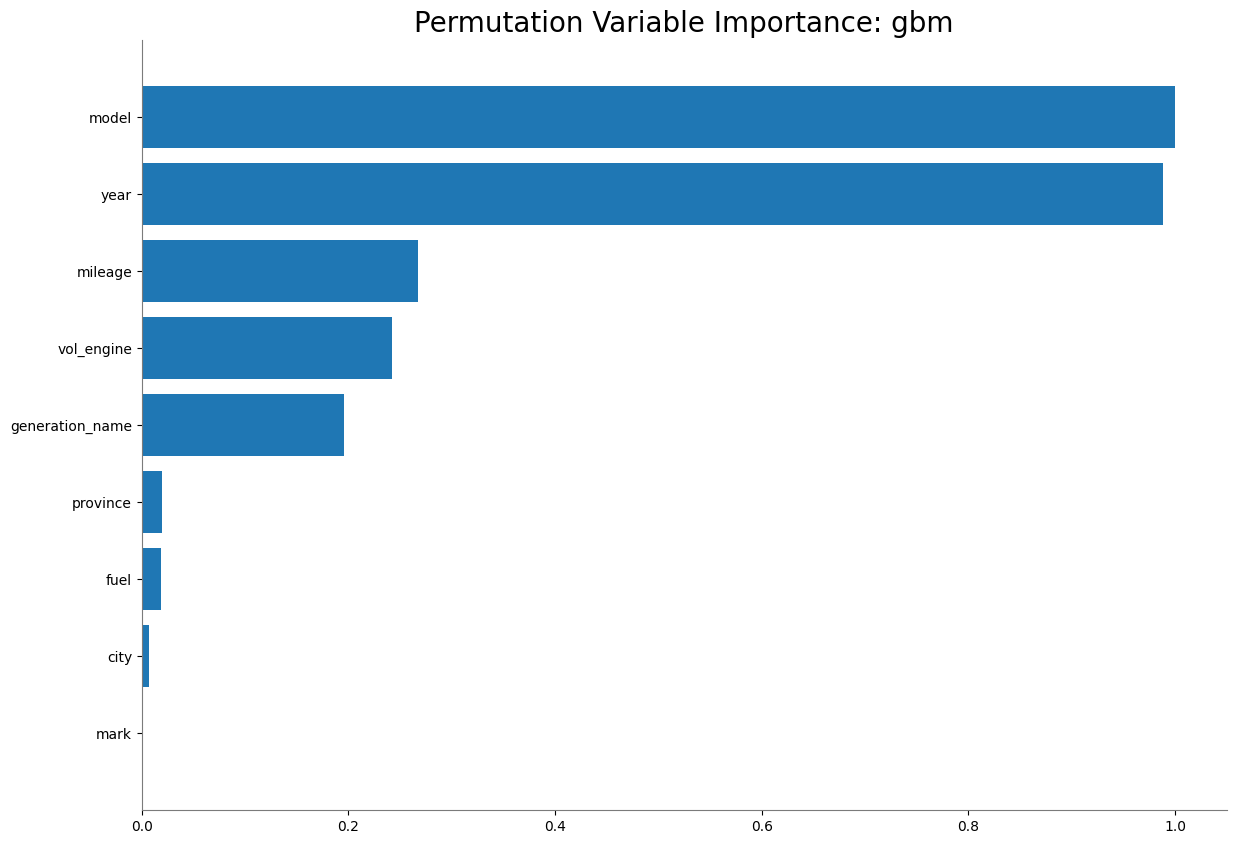

Variable,Relative Importance,Scaled Importance,Percentage
model,47769.9587142,1.0,0.3649540
year,47213.3112971,0.9883473,0.3607013
mileage,12781.4222850,0.2675619,0.0976478
vol_engine,11585.2159158,0.2425210,0.0885090
generation_name,9331.1076415,0.1953342,0.0712880
province,958.5696269,0.0200664,0.0073233
fuel,894.6473496,0.0187282,0.0068349
city,351.3314634,0.0073547,0.0026841
mark,7.5283948,0.0001576,0.0000575


In [9]:
# plot permutation importance (bar plot)
gbm_model.permutation_importance_plot(test)

## Question 3

Calculate absolute error of the price on test dataset. Add absolute error column to the dataset and call it `abs_error`.   

Formula: `abs(price-predict_price)`

### Solution Q3

In [10]:
test = h2o.import_file('./data/Car_Prices_Poland_test.csv')
predict_price = gbm_model.predict(test)
predict_price.columns = ["predict_price"]
test = test.cbind(predict_price)
abs_error = abs(test["price"] - test["predict_price"])
#abs_error = abs_error/test["price"]
abs_error.columns = ["abs_error"]
test = test.cbind(abs_error)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [11]:
test

mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,predict_price,abs_error
skoda,octavia,gen-iii-2013,2016,63000,1598,Diesel,Szamotuły,Wielkopolskie,49500,56884.1,7384.14
ford,mustang,,1967,1,6384,Gasoline,Łódź,Łódzkie,379900,428271,48370.7
mini,cooper,,2016,125600,1998,Gasoline,Poznań,Wielkopolskie,99800,73710.9,26089.1
hyundai,santa-fe,gen-iii-2012-santa-fe,2014,270000,2199,Diesel,Radziejów,Kujawsko-pomorskie,59900,80172.2,20272.2
renault,clio,gen-v-2019,2019,24000,999,Gasoline,Leszno,Wielkopolskie,56999,50220.2,6778.83
bmw,seria-3,gen-e46-1998-2007,2003,248000,2171,LPG,Świebodzice,Dolnośląskie,13900,11626.9,2273.14
volkswagen,tiguan,gen-ii-2016-tiguan,2018,26500,1498,Gasoline,Swarzędz,Wielkopolskie,117500,110545,6954.78
ford,mustang,,1966,47522,4700,Gasoline,Repki,Mazowieckie,59900,119775,59875.4
fiat,500,,2021,7,0,Electric,Warszawa,Mazowieckie,160000,140283,19717.2
volkswagen,caddy,gen-iv-2015,2021,10,1968,Diesel,Łódź,Łódzkie,140046,150338,10292.5


## Question 4

Calculate and display summary plot of Shapley values. Use `test` dataset to calculate Shapley values.

- What is the most important feature based on Shapley values? 
- Based on the Summary plot, how features `year` and `mileage` affect model prediction of the car price?  

In [12]:
def examine_all_reason_codes(data, model, alpha=1):
    
    shap_contribs = model.predict_contributions(data)
    
    col_mapping = {}
    for i in data.col_names: 
        related_cols = [x for x in shap_contribs.col_names if "{}.".format(i) in x]
        if len(related_cols) > 0:
            col_mapping[i] = related_cols
            
    for k, v in col_mapping.items():
        if len(v) > 1:
            shap_contribs[k] = shap_contribs[v].sum(axis=1,return_frame=True)
            shap_contribs = shap_contribs.drop(v)
        
    shap_cols = [i for i in shap_contribs.col_names if i != "BiasTerm"]
    bias_term = shap_contribs.as_data_frame()["BiasTerm"].values
    
    #Convert to Pandas DF
    X = data.as_data_frame(use_pandas=True)
    shap_contribs = shap_contribs.as_data_frame(use_pandas=True)
    
    return shap.summary_plot(shap_contribs[shap_cols].values, 
                             X[shap_cols].values,
                             feature_names=shap_cols,
                             alpha=alpha,
                             plot_size=(10,10)
                            )

The order features are appearing on summary plot is based on feature importance, which is calculated as sum or average of the abosulute shapley values.

In [13]:
shap_contribs = gbm_model.predict_contributions(test)
df = shap_contribs.as_data_frame(use_pandas=True)
print("Sum Absolute Shapley values for:")
print("year: ",df["year"].abs().sum().round(0))
print("model:",df["model"].abs().sum().round(0))

contributions progress: |████████████████████████████████████████████████████████| (done) 100%
Sum Absolute Shapley values for:
year:  968637083.0
model: 603004536.0


contributions progress: |████████████████████████████████████████████████████████| (done) 100%


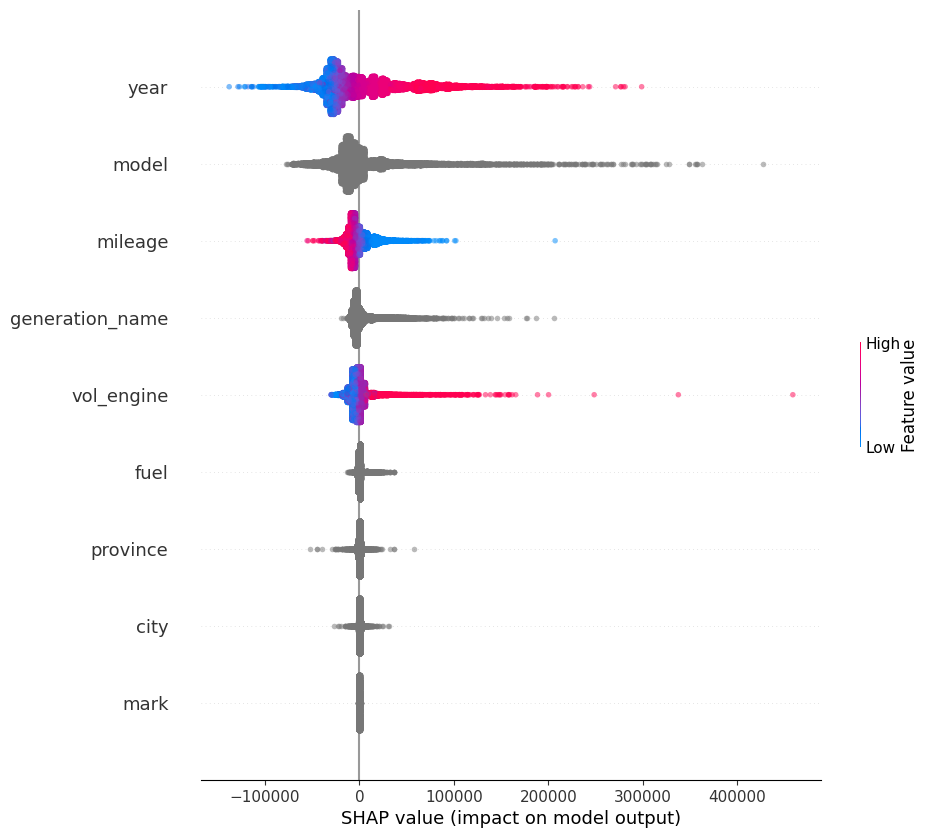

In [14]:
examine_all_reason_codes(test, gbm_model,alpha=0.5)

"year" - generally higher the year (newer the car) the price is impacted in the positive direction  

"mileage" - higher the mileage lower rhe price 

## Question 5

Plot individual Shapley values plots for records top 3 and bottom 3 records based on the residuals, for the total of 6 plots.  

Explain each plot in terms of what are most influential features and how they impact model prediction, and why you think model was correct for the top 3 records (smallest residuals) and significantly incorrect for the bottom 3 records (largest residuals).


In [15]:
test_sort = test.sort(["abs_error"])

test_sort.head(5)

mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,predict_price,abs_error
mercedes-benz,b-klasa,gen-w245-2005-2011,2009,225000,1991,Diesel,Ostrołęka,Mazowieckie,19900,19900.1,0.0856325
opel,meriva,gen-ii-2010,2011,160230,1686,Diesel,Góra Kalwaria,Mazowieckie,22800,22800.1,0.111867
opel,insignia,gen-a-2008-2017,2009,161000,1956,Diesel,Dąbrowa Górnicza,Śląskie,26999,26998.9,0.136393
ford,focus,gen-mk2-2004-2011,2009,182000,1596,Gasoline,Ostrołęka,Mazowieckie,15800,15799.6,0.380003
opel,astra,gen-h-2004-2013,2007,165000,1796,Gasoline,Włoszakowice,Wielkopolskie,14100,14100.5,0.527115


In [16]:
test_sort.tail(5)

mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,predict_price,abs_error
audi,e-tron,,2021,9000,0,Electric,Gliwice,Śląskie,803900,435190,368710
bmw,x7,,2021,17500,2993,Diesel,Bielsko-Biała,Śląskie,85000,518312,433312
mercedes-benz,clk-klasa,gen-w209-2002,2008,47600,6208,Gasoline,Gdańsk,Pomorskie,619900,114424,505476
mercedes-benz,g-klasa,gen-w463-1992,2018,98,5980,Gasoline,Warszawa,Mazowieckie,850000,1.39666e+06,546662
mercedes-benz,s-klasa,gen-w223-2020,2021,9000,2999,Gasoline,Sosnowiec,Śląskie,73800,742743,668943


In [17]:
# The function is to calculate Shapley values (contributions) and plot them for single record
def examine_indiv_reason_codes(record, model, use_matplotlib=True):
    
    shap_contribs = model.predict_contributions(record)
    
    col_mapping = {}
    for i in record.col_names: 
        related_cols = [x for x in shap_contribs.col_names if "{}.".format(i) in x]
        if len(related_cols) > 0:
            col_mapping[i] = related_cols
            
    for k, v in col_mapping.items():
        if len(v) > 1:
            shap_contribs[k] = shap_contribs[v].sum(axis=1,return_frame=True)
            shap_contribs = shap_contribs.drop(v)
        
    shap_cols = [i for i in shap_contribs.col_names if i != "BiasTerm"]
    bias_term = shap_contribs.as_data_frame()["BiasTerm"].values
    X = record.as_data_frame(use_pandas=True)
    shap_contribs = shap_contribs.as_data_frame(use_pandas=True)
    
    return shap.force_plot(bias_term, 
                           shap_contribs[shap_cols].values, 
                           X[shap_cols].values, 
                           shap_cols,
                           #link="logit",
                           matplotlib=use_matplotlib
                          )

In [18]:
shap.initjs()
#The non matplotlib version produces better graphics but cannot be saved with notebook
examine_indiv_reason_codes(test_sort[0, :], gbm_model, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


In [19]:
examine_indiv_reason_codes(test_sort[1, :], gbm_model, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


In [20]:
examine_indiv_reason_codes(test_sort[2, :], gbm_model, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


In [21]:
test_sort.shape

(29482, 12)

In [22]:
test_sort[29481, :]

mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,predict_price,abs_error
mercedes-benz,s-klasa,gen-w223-2020,2021,9000,2999,Gasoline,Sosnowiec,Śląskie,73800,742743,668943


In [23]:
examine_indiv_reason_codes(test_sort[29481, :], gbm_model, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


In [24]:
examine_indiv_reason_codes(test_sort[29480, :], gbm_model, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


In [25]:
examine_indiv_reason_codes(test_sort[29479, :], gbm_model, use_matplotlib=False)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


## Question 6 

Train new H2O GBM model on the test dataset trying to predict residuals. This is your surrogate modedel that you will use to understand what features are driving high residuals.   

Use same parameters as in question #1, except:
  - predictor is now "abs_error"
  - dataset now is "test" dataset
  - make sure not to include original "price" column in the model

Plot Shapley summary plot for the top 100 records with highest residuals.
Answer following question:
  - What is the most important feature of the surrogate model that impacts high residuals?

### Solution

In [26]:
from h2o.estimators import H2OGradientBoostingEstimator
response = "abs_error"
predictors_gbm = test_sort.columns
predictors_gbm.remove(response)
predictors_gbm.remove("price")
predictors_gbm.remove("predict_price")

gbm_res_model = H2OGradientBoostingEstimator(nfolds=5,
                                         ntrees=500,
                                         stopping_rounds=5,
                                         stopping_metric='MAE',
                                         seed=1234,
                                         keep_cross_validation_predictions = False)

gbm_res_model.train(x=predictors_gbm, y=response, training_frame=test_sort)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1680999406952_297


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    45                 45                          33564                  5            5            5             8             31            20.7778

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 111002332.58540529
RMSE: 10535.764451875588
MAE: 4931.230744134295
RMSLE: 1.2196138030588712
Mean Residual Deviance: 111002332.58540529

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 175733396.54538545
RMSE: 13256.447357621326
MAE: 5461.876850600809
RMSLE: NaN
Mean Residual Deviance: 175733396.54538545

Cross-Validation Metrics Summary: 
                        mean         sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     5464.62      127.715     5592.79       5331.23       5604.72       5431.09       5363.26
mean_residual_deviance  1.76295e+08  4.3434e+07  2.43404e+08   1.58979e+08   1.50509e+08   1.94204e+08   1.34379e+08
mse                     1.76295e+08  4.3434e+07  2.43404e+08   1.58979e+08   1.50509e+08   1.94204e+08   1.34379e+08
r2                      0.356302     0.0209821   0.333492      0.361036      0.342835      0.35565       0.388496
residual_deviance       1.76295e+08  4.3434e+07  2.43404e+08   1.58979e+08   1.50509e+08   1.94204e+08   1.34379e+08
rmse                    13201.2      1589.88     15601.4       12608.7       12268.2       13935.7       11592.2
rmsle                   1.22791      0.00287141  nan           nan           nan           1.22994       1.22588

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse       training_mae       training_deviance
---  -------------------  ----------  -----------------  ------------------  -----------------  -------------------
     2023-04-11 00:09:07  2.289 sec   0.0                16517.527144181116  7870.217819971412  272828702.95875996
     2023-04-11 00:09:07  2.299 sec   1.0                15843.79187353214   7461.866908841504  251025740.9318031
     2023-04-11 00:09:07  2.307 sec   2.0                15274.400209632071  7127.302225189853  233307301.76400825
     2023-04-11 00:09:07  2.316 sec   3.0                14782.209327587378  6841.876827549185  218513712.60461125
     2023-04-11 00:09:07  2.323 sec   4.0                14370.380436017218  6606.840029275026  206507833.87586638
     2023-04-11 00:09:07  2.332 sec   5.0                14016.204745781703  6408.073373124133  196453995.47567353
     2023-04-11 00:09:07  2.340 sec   6.0                13717.747261781346  6236.888852696414  188176589.9381096
     2023-04-11 00:09:07  2.350 sec   7.0                13462.597399667771  6087.890012848822  181241528.74554145
     2023-04-11 00:09:07  2.358 sec   8.0                13217.729034916125  5956.946988026472  174708360.84046474
     2023-04-11 00:09:07  2.367 sec   9.0                12992.714363048275  5840.78808583549   168810626.51976097
---  ---                  ---         ---                ---                 ---                ---
     2023-04-11 00:09:07  2.589 sec   36.0               10805.519207346575  4994.96922557969   116759245.34033576
     2023-04-11 00:09:07  2.597 sec   37.0               10770.405785255498  4985.262882216313  116001640.7790651
     2023-04-11 00:09:07  2.606 sec   38.0               10725.099950858781  4972.266364549184  115027768.95591103
     2023-04-11 00:09:07  2.614 sec   39.0               10716.744748364217  4

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


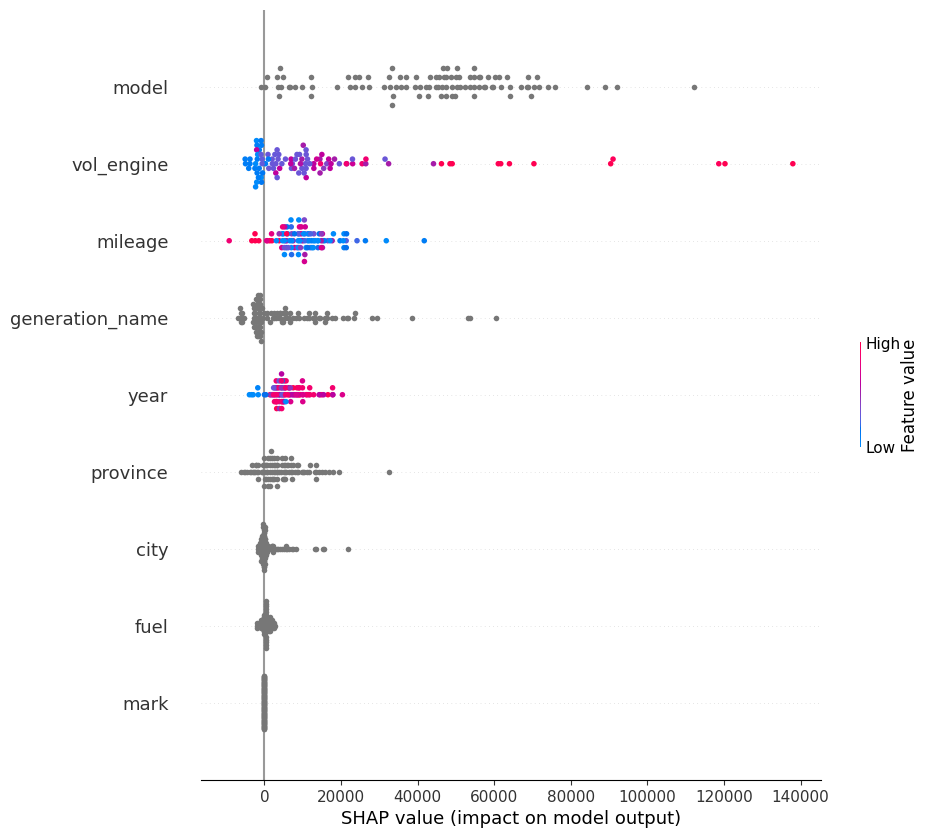

In [27]:
examine_all_reason_codes(test_sort.tail(100),gbm_res_model)